## Mean-Variance Optimization with risky asset and cash

## Purpose:

* Reinforcement learning is applied to the problem of optimal allocation
* The least squares policy iteration (LSPI) algorithm is applied to a Monte Carlo simulation of a stock's price movements, constructing a basis over the state-action space using B-spline basis functions at each time period.
* The optimal Q-function is approximated with a dynamic programming approach, and this is shown to approach the exact solution

In [1]:
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import norm

from bspline import Bspline, splinelab

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters for MC simulation of stock prices

In [2]:
S0 = 100 # Initial stock price
mu = 0.03 # Drift
sigma = 0.20 # Volatility
r = 0.01 # Risk-free rate
M = 1 # Maturity

T = 30 # Number of time steps
delta_t = M / T # Time interval

N_MC = 2000 # Number of paths

gamma = np.exp(- r * delta_t) # Discount factor
lmbda = 10.0 # Risk aversion
alpha = 1.0 # Learning rate

## Create dataset

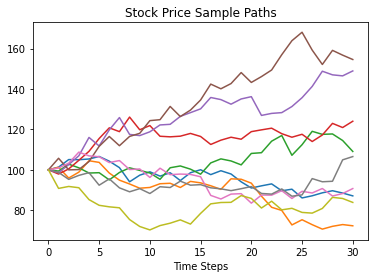

In [3]:
# Stock price
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:, 0] = S0

# Standard normal random numbers
RN = pd.DataFrame(np.random.randn(N_MC, T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:, t] = S.loc[:, t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:, t])
    
    # Or, using Euler for alpha-stable distributions:
    #S.loc[:, t] = S.loc[:, t-1]*(1 + mu*delta_t + sigma *S.loc[:,t-1]**(alpha-1)*np.sqrt(delta_t) * RN.loc[:,t])

# Plot 10 paths
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.title('Stock Price Sample Paths')
plt.show()


$$C_t = -R_t= -r_t  + \lambda (r_t-\mu)^2  =  -(1-u_t)r_f - u_t  \phi_t  +  \lambda u_t^2 Var(\phi_t | S_t)$$ 

In [4]:
def negative_reward(mu, var, a, rf, lmbda):
    C = -(1-a)*rf - a*mu + lmbda*(a**2)*var
    return C

##  Define spline basis functions  

In [5]:
X = S # set the wealth (but not the total wealth) of the portfolio to be the stock price
p = 4 # order of spline (as-is; 3 = cubic, 4: B-spline)
ncolloc = 16
a_min = -1
a_max = 1

In [6]:
def get_basis_functions(X_min, X_max, a_min, a_max, ncolloc, p=3):
    tau_x = np.linspace(X_min, X_max, ncolloc)  # These are the sites to which we
    tau_a = np.linspace(a_min, a_max, ncolloc)  # would like to interpolate

    # k is a knot vector that adds endpoints repeats as appropriate for a spline of order p
    # To get meaninful results, one should have ncolloc >= p+1
    k_x = splinelab.aptknt(tau_x, p)
    k_a = splinelab.aptknt(tau_a, p)
                             
    # Spline basis of order p on knots k
    basis_x = Bspline(k_x, p)
    basis_a = Bspline(k_a, p)
    return basis_x, basis_a

### Make data matrices with feature values

"Features" here are the values of basis functions at data points
The outputs are 3D arrays of dimensions num_tSteps x num_MC x num_basis

In [7]:
num_t_steps = T + 1
num_basis =  ncolloc**2 

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))

In [8]:
x = X.values[:, 0]
np.shape(x)

(2000,)

## Compute the optimal Q-function with the DP approach 

Coefficients for expansions of the optimal Q-function $Q_t^\star\left(X_t,a_t^\star\right)$ are solved by

$$W_t=\mathbf S_t^{-1}\mathbf M_t$$

where $\mathbf S_t$ and $\mathbf M_t$ are matrix and vector respectively with elements given by

$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\Phi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k,a_t^k\right)\left(C\left(X_t^k,a_t^k,X_{t+1}^k\right)+\gamma\min_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1}^k,a_{t+1}^k\right)\right)}$$

Define function *function_S* and *function_M* to compute the value of matrix $\mathbf S_t$ and vector $\mathbf M_t$.

In [9]:
def function_S_vec(t, data_mat_t):
    # Compute the matrix S_{nm} 
    X_mat = data_mat_t[t, :, :]
    num_basis_funcs = X_mat.shape[1]    
    S_mat = np.dot(X_mat.T, X_mat)
    return S_mat

def function_M_vec(t, Q, R, data_mat_t, gamma=0.1):
    X_mat = data_mat_t[t,:,:]
    tmp = R + gamma * np.min(Q[:, t+1])  # note that the second argument in Q is t+1
    M = np.dot(X_mat.T, tmp)
    return M

### Least Squares Policy Iteration
Call *function_S* and *function_M* for $t=T-1,...,0$ together with basis function $\Phi_n\left(X_t,a_t\right)$ to compute optimal action Q-function $Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t,a_t^\star\right)}$ backward recursively with terminal condition $Q_T^\star\left(X_T,a_T=0\right)=0$.



#### Initialize data structures

In [10]:
mu = np.zeros(T)
var = np.zeros(T)

# optimal action
a_opt = np.zeros((N_MC, T))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:, -1] = 0

# optimal Q-function with optimal action
max_Q_star = np.zeros((N_MC, T))

a_mean = []

#### initialize actions in feasible region [0, a_max]

In [11]:
grid_size_x = 20
grid_size_a = 500 

# set up a small grid, sufficiently nested inside the support of the basis functions
a_min_prime = a_min + 0.1
a_max_prime = a_max - 0.1

a_grid = np.linspace(a_min_prime, a_max_prime, grid_size_a)

Q_star = np.zeros((N_MC, T))
tau = 1e-6
a = a_min_prime + (a_max_prime - a_min_prime) * np.random.rand(N_MC)

There are *grid_size_x* $\times$ *grid_size_a* inner grid points and 256 basis functions. Let $(k,l)$ denote the indices of the smaller grid $\Omega^h$. Let $(i,j)$ denote the indices of the knot points of the basis functions. If you sum over the last index, then you can check the interpolation of ones
$$f(x_k,a_l)=\sum_{ij} \Phi(x_k,a_l)f_{ij}$$
check if $f_{ij}=1$ everywhere
$$f(x,a)=\sum_{ij} \Phi(x,a)1 =1, \forall x,a ?$$

#### The backward loop

*Make sure to rerun cells under the heading* **'Initialize data structures'** *to reset the initial conditions before running this cell*

In [ ]:
for t in np.arange(T - 2, 0, -1):
    error = tau
    q_prev = np.zeros(N_MC)  
    ret = (S.loc[:, t+1] - S.loc[:, t]) / S.loc[:, t]
    mu[t] = np.mean(ret)
    var[t] = np.var(ret)
    count = 0
    max_iter = 100
    x = X.values[:, t]
    basis_x, basis_a = get_basis_functions(np.min(x)-10, np.max(x)+10, a_min, a_max, ncolloc, p)
    x_grid = np.linspace(np.min(x), np.max(x), grid_size_x)
    Phi_mat = np.array([[np.kron(basis_x(x_grid[i]), basis_a(a_grid[j])).reshape(num_basis, 1) 
                         for i in range(grid_size_x)] for j in range(grid_size_a)])[:, :, :, 0]   
        
    while (np.abs(error)>=tau) and (count<max_iter):
       
        R = negative_reward(mu[t], var[t], a, r, lmbda)
        data_mat_t[t, :, :] = np.array([np.kron(basis_x(x[i]), basis_a(a[i])).reshape(num_basis, 1) for i in range(N_MC)])[:, :, 0]
        
        # Check partition of unity
        h = np.dot(data_mat_t[t],np.ones(np.shape(data_mat_t[t])[1]))
        if np.sum(h) != N_MC:
            print("error: loss of partition of unity")
        S_t = function_S_vec(t, data_mat_t) 
        M_t = function_M_vec(t, Q_star, R, data_mat_t, gamma)
        W_t = np.dot(np.linalg.pinv(S_t), M_t)
       
        # Compute Q_t matrix over small grid
        # Phi_mat is the matrix for interpolating over the smaller x * a grid
        Q_t = np.dot(Phi_mat, W_t) # gridded Q_t
        
        print("residual error: ||r||=||Sw-M||")
        print(np.linalg.norm(np.dot(S_t, W_t) - M_t))
        
        # Find the optimal action on the small grid
        a_idx =  np.argmin(Q_t, axis=0)
        # Need to interpolate over X 
        a_star_ = np.zeros(grid_size_x, dtype='float64')
        
        for j in range(grid_size_x):
            a_star_[j] = a_grid[a_idx[j]]
    
        f = interp1d(x_grid, a_star_, kind='cubic')
        a_prime = f(x)
        
        # Only update the actions along the paths where the neg. reward is lowered
        R_prime = negative_reward(mu[t], var[t], a_prime, r, lmbda)
        idx = np.where(R_prime>R)
        a_prime[idx] = a[idx]
        a = a_prime
        a_mean.append(np.mean(a))
        Q_star[:,t] = np.dot(data_mat_t[t, :, :], W_t)
        error = np.linalg.norm(Q_star[:, t] - q_prev)
        
        q_prev = np.copy(Q_star[:, t])
        
        print('count, Q error, E[R], E[a]')
        print(count, error, np.mean(R), np.mean(a))
        count += 1 
       
    a_opt[:, t] = a  

residual error: ||r||=||Sw-M||
9.47483264365377e-08
count, Q error, E[R], E[a]
0 0.3916463660570184 -0.006432356787881904 -0.36204931829968623
residual error: ||r||=||Sw-M||
0.010550671719543273
count, Q error, E[R], E[a]
1 0.3567417218022173 -0.011740677098248787 -0.3623515206055361
residual error: ||r||=||Sw-M||
0.0006136857299169039
count, Q error, E[R], E[a]
2 0.0011148673384058603 -0.011741354635012765 -0.36240702392507784
residual error: ||r||=||Sw-M||
0.0009247690895847314
count, Q error, E[R], E[a]
3 0.00028942771900707456 -0.011741412416208064 -0.3624362402847759
residual error: ||r||=||Sw-M||
0.0002277296813236558
count, Q error, E[R], E[a]
4 0.00022995593899189404 -0.011741478110456841 -0.362503678050369
residual error: ||r||=||Sw-M||
1.7310190908456394e-05
count, Q error, E[R], E[a]
5 0.00016790034209177948 -0.01174156419992574 -0.36251313252565887
residual error: ||r||=||Sw-M||
1.0154694548896108e-06
count, Q error, E[R], E[a]
6 1.6063629884947933e-05 -0.011741569843543933

residual error: ||r||=||Sw-M||
0.0031780648868549436
count, Q error, E[R], E[a]
4 0.00029321072130460103 -0.011687675057140133 -0.36289948978464975
residual error: ||r||=||Sw-M||
0.006584695843540191
count, Q error, E[R], E[a]
5 0.0009872939368776035 -0.011688141212588427 -0.36254553449629207
residual error: ||r||=||Sw-M||
0.017294074820370993
count, Q error, E[R], E[a]
6 0.0031252907111187283 -0.011688182498529208 -0.36247413634274916
residual error: ||r||=||Sw-M||
0.009849174330309072
count, Q error, E[R], E[a]
7 0.0022888824026380916 -0.011688244497998285 -0.3624964657865105
residual error: ||r||=||Sw-M||
0.015192544123042526
count, Q error, E[R], E[a]
8 0.002712745079996064 -0.011688268440927827 -0.36252337419971015
residual error: ||r||=||Sw-M||
0.030445745931057172
count, Q error, E[R], E[a]
9 0.005825464288426651 -0.011688269997439743 -0.36250607565604964
residual error: ||r||=||Sw-M||
0.0061089611912873406
count, Q error, E[R], E[a]
10 0.005136547991903865 -0.011688270590611408

residual error: ||r||=||Sw-M||
0.021439231988250484
count, Q error, E[R], E[a]
47 0.002308764807109556 -0.011962887417488207 -0.39212459859457277
residual error: ||r||=||Sw-M||
0.021767828036315218
count, Q error, E[R], E[a]
48 0.003978982524636771 -0.01196288741753548 -0.39212688993595485
residual error: ||r||=||Sw-M||
0.02150695875518934
count, Q error, E[R], E[a]
49 0.003816274017478898 -0.011962887467109638 -0.3921239693285187
residual error: ||r||=||Sw-M||
0.016302052599082094
count, Q error, E[R], E[a]
50 0.0033895934205704957 -0.011962887501229277 -0.39213004763500503
residual error: ||r||=||Sw-M||
0.010996851626561048
count, Q error, E[R], E[a]
51 0.0025072302800604423 -0.0119628876000494 -0.3921293619860519
residual error: ||r||=||Sw-M||
0.012716110132013073
count, Q error, E[R], E[a]
52 0.0023415748915971784 -0.011962887631776947 -0.3921278783324188
residual error: ||r||=||Sw-M||
0.011481501356001818
count, Q error, E[R], E[a]
53 0.0012258207764104672 -0.011962887650004923 -0

residual error: ||r||=||Sw-M||
9.531250275356634e-05
count, Q error, E[R], E[a]
4 1.379498056399295e-05 -0.011405804361573431 -0.3260846697429113
residual error: ||r||=||Sw-M||
9.531250275356634e-05
count, Q error, E[R], E[a]
5 0.0 -0.011405804361573431 -0.3260846697429113
residual error: ||r||=||Sw-M||
0.0001258489943391388
count, Q error, E[R], E[a]
0 5.7759834057472075 -0.012110253497428733 -0.3666873173856246
residual error: ||r||=||Sw-M||
0.05837509349103339
count, Q error, E[R], E[a]
1 0.008922525334406677 -0.012172957966336932 -0.36798868770207593
residual error: ||r||=||Sw-M||
0.0030190431017876095
count, Q error, E[R], E[a]
2 0.00739384790342227 -0.012174168486771006 -0.37825247826240516
residual error: ||r||=||Sw-M||
0.0005448063614370323
count, Q error, E[R], E[a]
3 0.00031116914427554526 -0.012182082883951327 -0.38977786404982667
residual error: ||r||=||Sw-M||
0.02880873609654137
count, Q error, E[R], E[a]
4 0.0023399181014609437 -0.012188056110416146 -0.39138600150474445
r

residual error: ||r||=||Sw-M||
0.02283801904671612
count, Q error, E[R], E[a]
14 0.004833740850229904 -0.011005653450114049 -0.2650162659188378
residual error: ||r||=||Sw-M||
0.0509993187532067
count, Q error, E[R], E[a]
15 0.005171649509770227 -0.011005655028923329 -0.2650146556887697
residual error: ||r||=||Sw-M||
0.015651031432402436
count, Q error, E[R], E[a]
16 0.005722281946646036 -0.011005655136504956 -0.26499042236498527
residual error: ||r||=||Sw-M||
0.026552081184820078
count, Q error, E[R], E[a]
17 0.0032997828518160177 -0.011005655918017755 -0.2649644795855859
residual error: ||r||=||Sw-M||
0.06460491628823611
count, Q error, E[R], E[a]
18 0.007915186659341192 -0.011005656964784168 -0.26479507616086867
residual error: ||r||=||Sw-M||
0.10194864245328907
count, Q error, E[R], E[a]
19 0.014057435776604489 -0.011005661057066565 -0.2646978976790107
residual error: ||r||=||Sw-M||
0.061306842055885845
count, Q error, E[R], E[a]
20 0.0051357174741119786 -0.01100566312209312 -0.2647

residual error: ||r||=||Sw-M||
0.0013114115129328689
count, Q error, E[R], E[a]
2 0.0014180632003461555 -0.011220521152739532 -0.3008485386444661
residual error: ||r||=||Sw-M||
0.006048167436493211
count, Q error, E[R], E[a]
3 0.0006127791359115733 -0.01122588731927936 -0.2929239881797532
residual error: ||r||=||Sw-M||
0.03746817673125821
count, Q error, E[R], E[a]
4 0.003375885892107468 -0.011227249714888905 -0.29258318685395646
residual error: ||r||=||Sw-M||
0.0004639604505980698
count, Q error, E[R], E[a]
5 0.0035626855072089583 -0.011227417285873178 -0.29098260673596665
residual error: ||r||=||Sw-M||
0.017638991549018292
count, Q error, E[R], E[a]
6 0.0018783985534082898 -0.01122754509500103 -0.29096485221696555
residual error: ||r||=||Sw-M||
0.022254969845831866
count, Q error, E[R], E[a]
7 0.002108073329256128 -0.011227562500906374 -0.29129350733991394
residual error: ||r||=||Sw-M||
0.012302939407822181
count, Q error, E[R], E[a]
8 0.0029301882709020103 -0.011227574665950002 -0.2

residual error: ||r||=||Sw-M||
0.02508227615494906
count, Q error, E[R], E[a]
32 0.00443361092365743 -0.011558029668824663 -0.34102052514620657
residual error: ||r||=||Sw-M||
0.023548147470024896
count, Q error, E[R], E[a]
33 0.004157319745180832 -0.011558029671754792 -0.3410202210093053
residual error: ||r||=||Sw-M||
0.012749730421915285
count, Q error, E[R], E[a]
34 0.003005191428750202 -0.011558029673703306 -0.3410235298737968
residual error: ||r||=||Sw-M||
0.014387601979472689
count, Q error, E[R], E[a]
35 0.0014495564080819778 -0.011558029678365942 -0.3410257266308733
residual error: ||r||=||Sw-M||
0.009615851735464226
count, Q error, E[R], E[a]
36 0.0022510173037480615 -0.011558029682557126 -0.3410268753514712
residual error: ||r||=||Sw-M||
0.00530661932117284
count, Q error, E[R], E[a]
37 0.001598686232419167 -0.011558029686271207 -0.34103030002980184
residual error: ||r||=||Sw-M||
0.014255514170386797
count, Q error, E[R], E[a]
38 0.0014736520403007213 -0.011558029696275863 -0.

residual error: ||r||=||Sw-M||
0.035956192163104396
count, Q error, E[R], E[a]
10 0.006404339557336331 -0.011125849406388862 -0.28930708380035014
residual error: ||r||=||Sw-M||
0.09105976439863518
count, Q error, E[R], E[a]
11 0.010387508216220155 -0.011125849721760957 -0.2893149803795144
residual error: ||r||=||Sw-M||
0.10358114275825046
count, Q error, E[R], E[a]
12 0.005011910414600795 -0.011125849798545747 -0.28933178332313436
residual error: ||r||=||Sw-M||
0.0578164681875867
count, Q error, E[R], E[a]
13 0.008277550392892507 -0.011125850127867537 -0.2893350288226721
residual error: ||r||=||Sw-M||
0.057289737703909896
count, Q error, E[R], E[a]
14 0.004739297149998745 -0.011125850510123556 -0.28938731615041857
residual error: ||r||=||Sw-M||
0.07306329111832793
count, Q error, E[R], E[a]
15 0.010650519659771871 -0.011125850778963244 -0.2894258660575952
residual error: ||r||=||Sw-M||
0.08256297569920491
count, Q error, E[R], E[a]
16 0.013112240613049674 -0.011125852043098572 -0.28944

In [ ]:
a_star_exact = []
a_star_approx = []
for t in range(1, T-1):
    a_star_exact.append((mu[t] - r) / (2 * lmbda * var[t]))
    a_star_approx.append(np.mean(a_opt[:, t]))

In [ ]:
plt.plot(a_star_approx)
plt.plot(a_star_exact, color='red')
plt.xlabel('time')
plt.ylabel('action');

In [ ]:
a_star_exact = (mu[t] - r) / (2 * lmbda * var[t])

In [ ]:
a_star_exact

In [ ]:
negative_reward(mu[t], var[t], a_star_exact, r, lmbda)

In [ ]:
a_ = np.arange(-1, 1, 0.01)
plt.plot(a_, negative_reward(mu[t], var[t], a_, r, lmbda))
plt.xlabel('S')
plt.ylabel('R');

In [ ]:
plt.plot(a_mean)
plt.plot(x_grid, a_star_)
plt.plot(x_grid, np.ones(len(x_grid)) * a_star_exact, color='black')
plt.ylim([-1, 1])

optimal action depends on lambda